In [5]:
%cd ~/cdv
import os

os.environ['CUDA_VISIBLE_DEVICES'] = ''

import numpy as np
import jax.numpy as jnp
import jax
import jax.random as jr
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp
import wat
from eins import EinsOp
import treescope

if os.environ['CUDA_VISIBLE_DEVICES'] == '':
    jax.config.update('jax_default_device', jax.devices('cpu')[0])

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

/home/nmiklaucic/cdv


/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
from pathlib import Path
import pyrallis
from facet.config import MainConfig
import orbax.checkpoint as ocp

from facet.training_state import TrainingRun
from facet.checkpointing import best_ckpt

# run_dir = Path('logs') / '08-31-22-23_488'
run_dir = Path('logs') / 'enb-158'

with open(run_dir / 'config.toml') as conf_file:
    config = pyrallis.cfgparsing.load(MainConfig, conf_file)

model = config.build_regressor()

ckpt = best_ckpt(run_dir)
# ckpt = jax.tree.map(lambda x: x if isinstance(x, (float, int)) else x.astype(jnp.float32), ckpt)
params = ckpt['state']['params']
ema_params = ckpt['state']['opt_state'][-1]['ema']['params']
mod = model.bind({'params': ema_params})

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:17                                                                                   │
│                                                                                                  │
│   14                                                                                             │
│   15 model = config.build_regressor()                                                            │
│   16                                                                                             │
│ ❱ 17 ckpt = best_ckpt(run_dir)                                                                   │
│   18 # ckpt = jax.tree.map(lambda x: x if isinstance(x, (float, int)) else x.astype(jnp.float    │
│   19 params = ckpt['state']['params']                                                            │
│   20 ema_params = ckpt['state']['opt_state'][-1]['ema']['params']                                │
│                                                                                                  │
│ /home/nmiklaucic/cdv/facet/checkpointing.py:30 in best_ckpt                                      │
│                                                                                                  │
│   27 │   │   ),                                                                                  │
│   28 │   )                                                                                       │
│   29 │                                                                                           │
│ ❱ 30 │   model = mngr.restore(mngr.best_step())                                                  │
│   31 │   return model                                                                            │
│   32                                                                                             │
│                                                                                                  │
│ /home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/orbax/checkpoint/checkpoint_m │
│ anager.py:1358 in restore                                                                        │
│                                                                                                  │
│   1355 │                                                                                         │
│   1356 │   restore_directory = self._get_read_step_directory(step, directory)                    │
│   1357 │   step_stats.checkpointer_start_time = time.time()                                      │
│ ❱ 1358 │   restored = self._checkpointer.restore(restore_directory, args=args)                   │
│   1359 │   step_stats.checkpointer_duration_secs = (                                             │
│   1360 │   │   time.time() - step_stats.checkpointer_start_time                                  │
│   1361 │   )                                                                                     │
│                                                                                                  │
│ /home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/orbax/checkpoint/async_checkp │
│ ointer.py:428 in restore                                                                         │
│                                                                                                  │
│   425   def restore(self, directory: epath.PathLike, *args, **kwargs) -> Any:                    │
│   426 │   """See superclass documentation."""                                                    │
│   427 │   self.wait_until_finished()                                                             │
│ ❱ 428 │   return super().restore(directory, *args, **kwargs)                                     │
│   429                                                                                            │
│   430   def check_for_errors(self):                        

In [3]:
import treescope as tz

tz.basic_interactive_setup()

In [4]:
from facet.utils import debug_structure


debug_structure(ema_params);

arg0
├── edge_embedding
│   ├── basis >>> freq
│   │   └── f32[10]
│   └── rmax
│       └── f32[1]
├── head
│   ├── Dense_0 >>> kernel
│   │   └── f32[128, 64]
│   └── Dense_1 >>> kernel
│       └── f32[64, 1]
├── mace
│   ├── layer_0
│   │   ├── interaction
│   │   │   ├── SimpleInteraction_0
│   │   │   │   ├── SevenNetConv_0
│   │   │   │   │   └── {...}
│   │   │   │   ├── linear_intro
│   │   │   │   │   └── {...}
│   │   │   │   └── linear_outro
│   │   │   │       └── {...}
│   │   │   └── resid_adapter >>> w[0,0] 128x0e,128x0e
│   │   │       └── f32[128, 128]
│   │   └── self_connection
│   │       ├── mlp
│   │       │   ├── Dense_0
│   │       │   │   └── {...}
│   │       │   ├── Dense_1
│   │       │   │   └── {...}
│   │       │   └── LayerNorm_0
│   │       │       └── {...}
│   │       ├── proj_down
│   │       │   ├── w[0,0] 192x0e,128x0e
│   │       │   │   └── f32[192, 128]
│   │       │   ├── w[1,1] 64x1e,64x1e
│   │       │   │   └── f32[64, 64]
│   │       │   └── w[2,2] 64x2e,32x2e
│   │       │       └── f32[64, 32]
│   │       └── proj_up
│   │           ├── w[0,0] 128x0e,64x0e
│   │           │   └── f32[128, 64]
│   │           ├── w[1,1] 64x1e,64x1e
│   │           │   └── f32[64, 64]
│   │           └── w[2,2] 32x2e,64x2e
│   │               └── f32[32, 64]
│   ├── layer_1
│   │   ├── interaction
│   │   │   ├── SimpleInteraction_0
│   │   │   │   ├── SevenNetConv_0
│   │   │   │   │   └── {...}
│   │   │   │   ├── linear_intro
│   │   │   │   │   └── {...}
│   │   │   │   └── linear_outro
│   │   │   │       └── {...}
│   │   │   └── resid_adapter
│   │   │       ├── w[0,0] 128x0e,128x0e
│   │   │       │   └── f32[128, 128]
│   │   │       ├── w[1,1] 64x1e,64x1e
│   │   │       │   └── f32[64, 64]
│   │   │       └── w[2,2] 32x2e,32x2e
│   │   │           └── f32[32, 32]
│   │   └── self_connection
│   │       ├── mlp
│   │       │   ├── Dense_0
│   │       │   │   └── {...}
│   │       │   ├── Dense_1
│   │       │   │   └── {...}
│   │       │   └── LayerNorm_0
│   │       │       └── {...}
│   │       ├── proj_down
│   │       │   ├── w[0,0] 192x0e,128x0e
│   │       │   │   └── f32[192, 128]
│   │       │   ├── w[1,1] 64x1e,64x1e
│   │       │   │   └── f32[64, 64]
│   │       │   └── w[2,2] 64x2e,32x2e
│   │       │       └── f32[64, 32]
│   │       └── proj_up
│   │           ├── w[0,0] 128x0e,64x0e
│   │           │   └── f32[128, 64]
│   │           ├── w[1,1] 64x1e,64x1e
│   │           │   └── f32[64, 64]
│   │           └── w[2,2] 32x2e,64x2e
│   │               └── f32[32, 64]
│   ├── layer_2
│   │   ├── interaction
│   │   │   ├── SimpleInteraction_0
│   │   │   │   ├── SevenNetConv_0
│   │   │   │   │   └── {...}
│   │   │   │   ├── linear_intro
│   │   │   │   │   └── {...}
│   │   │   │   └── linear_outro
│   │   │   │       └── {...}
│   │   │   └── resid_adapter
│   │   │       ├── w[0,0] 128x0e,128x0e
│   │   │       │   └── f32[128, 128]
│   │   │       ├── w[1,1] 64x1e,64x1e
│   │   │       │   └── f32[64, 64]
│   │   │       └── w[2,2] 32x2e,32x2e
│   │   │           └── f32[32, 32]
│   │   └── self_connection
│   │       ├── mlp
│   │       │   ├── Dense_0
│   │       │   │   └── {...}
│   │       │   ├── Dense_1
│   │       │   │   └── {...}
│   │       │   └── LayerNorm_0
│   │       │       └── {...}
│   │       ├── proj_down
│   │       │   ├── w[0,0] 192x0e,128x0e
│   │       │   │   └── f32[192, 128]
│   │       │   ├── w[1,1] 64x1e,64x1e
│   │       │   │   └── f32[64, 64]
│   │       │   └── w[2,2] 64x2e,32x2e
│   │       │       └── f32[64, 32]
│   │       └── proj_up
│   │           ├── w[0,0] 128x0e,64x0e
│   │           │   └── f32[128, 64]
│   │           ├── w[1,1] 64x1e,64x1e
│   │           │   └── f32[64, 64]
│   │           └── w[2,2] 32x2e,64x2e
│   │               └── f32[32, 64]
│   ├── layer_3
│   │   ├── interaction
│   │   │   ├── SimpleInteraction_0
│   │   │   │   ├── SevenNetConv_0
│   │   │   │   │   └── {...}
│   │   │   │   ├── linear_intro
│  

In [5]:

spec_emb = ema_params['node_embedding']['embed']['embedding'].astype(jnp.float32)

spec_df = pd.DataFrame(spec_emb, index=config.data.metadata.symbols).iloc[1:, :]
spec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
C,0.000165,-0.163735,0.809707,0.465409,0.225008,0.623081,-0.859812,-0.174784,-0.546590,-0.037149,...,-0.982884,-0.736490,-0.054359,-0.036998,0.007204,0.258183,0.298099,0.464526,0.215926,-0.449929
Cl,0.459605,-0.155931,0.152803,0.029183,-0.006428,-0.030610,-0.087408,0.328522,0.212019,0.231696,...,0.460380,0.204204,0.426359,0.413388,0.083722,0.347621,-0.042599,0.577719,0.015597,0.063593
Li,-0.033979,-0.278050,-0.778971,0.191478,0.263336,-0.266105,0.244141,-0.010217,0.814170,0.102235,...,0.161425,0.605894,-0.203114,-0.232852,0.339320,-0.084231,-0.100933,-0.084440,0.049665,0.592526
O,0.026856,-0.019077,0.028570,0.050598,-0.143566,0.097941,-0.062548,-0.010144,-0.090982,0.167339,...,-0.172597,-0.330937,-0.282333,0.026588,-0.092276,0.015887,-0.049548,0.223383,0.209263,-0.210068
P,0.322454,-0.206015,0.628358,0.561017,-0.069198,0.226580,-0.150275,0.046720,-0.060179,0.711021,...,-0.349661,0.034622,0.530089,-0.265663,0.099901,0.265545,0.218447,0.155596,-0.002920,-0.357174


<IPython.core.display.HTML object>

<seaborn.matrix.ClusterGrid object at 0x7df6cee0df70>

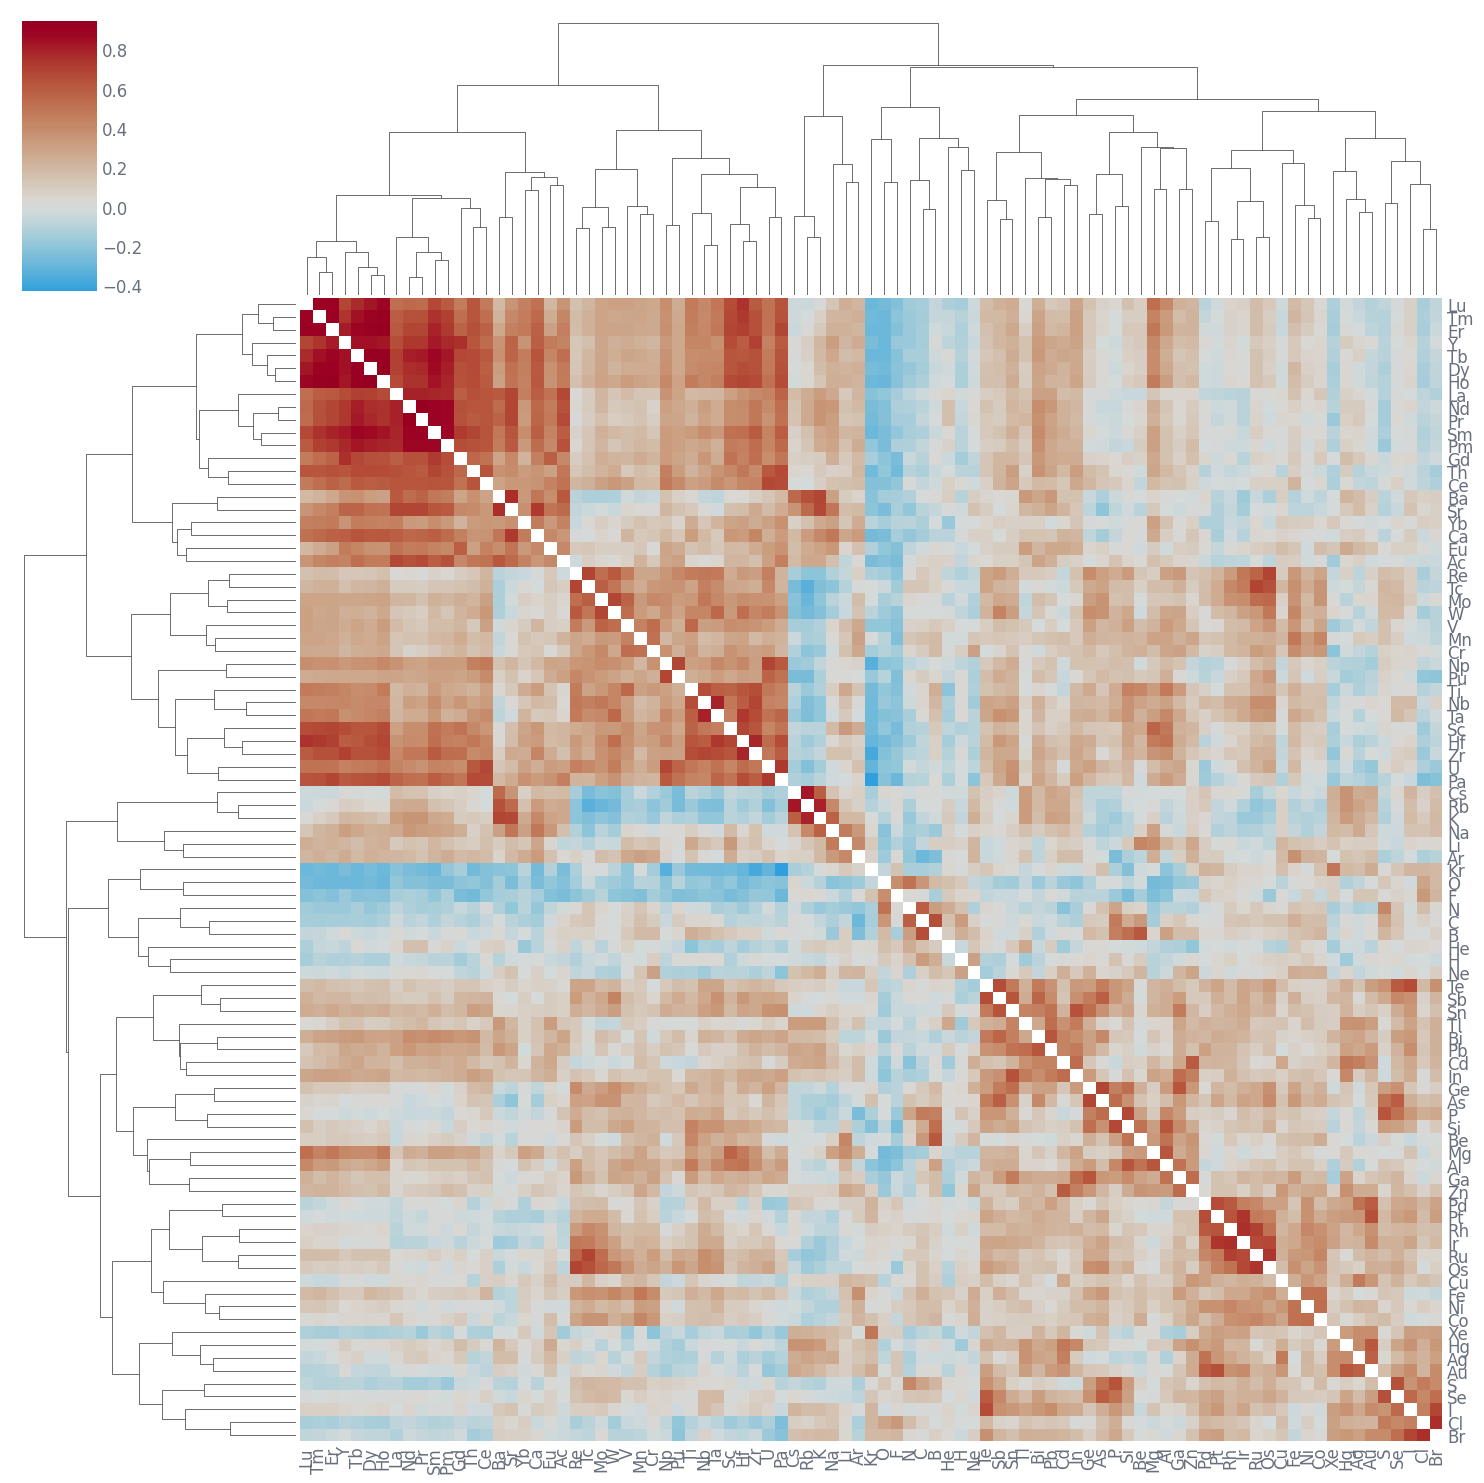

In [6]:
mat = spec_df.T.corr().iloc[::1, ::1]
sns.clustermap(mat, xticklabels=1, yticklabels=1, cmap='rho_diverging', center=0,
               mask=np.eye(mat.shape[0]), figsize=(15, 15))               

In [ ]:
# from umap import UMAP
# import plotly.express as px

# umap = UMAP(n_neighbors=20, metric='euclidean')

# spec_df[['x', 'y']] = umap.fit_transform(spec_df.drop(columns=['x', 'y'], errors='ignore').values)

# spec_df.columns = [str(c) for c in spec_df.columns]
# px.scatter(spec_df.reset_index(), x='x', y='y', text='index', width=800, height=800, opacity=0)

In [8]:
ema_params['edge_embedding']

<IPython.core.display.HTML object>

<IPython.core.display.HTML object>

{
    'basis': {
        'freq': Array([0.4984799 , 0.98216367, 1.485868  , 2.0818627 , 2.685792  ,
       3.3202503 , 3.9523911 , 4.5879803 , 1.6922276 , 3.135766  ],      dtype=float32)
    },
    'rmax': Array([4.410089], dtype=float32)
}

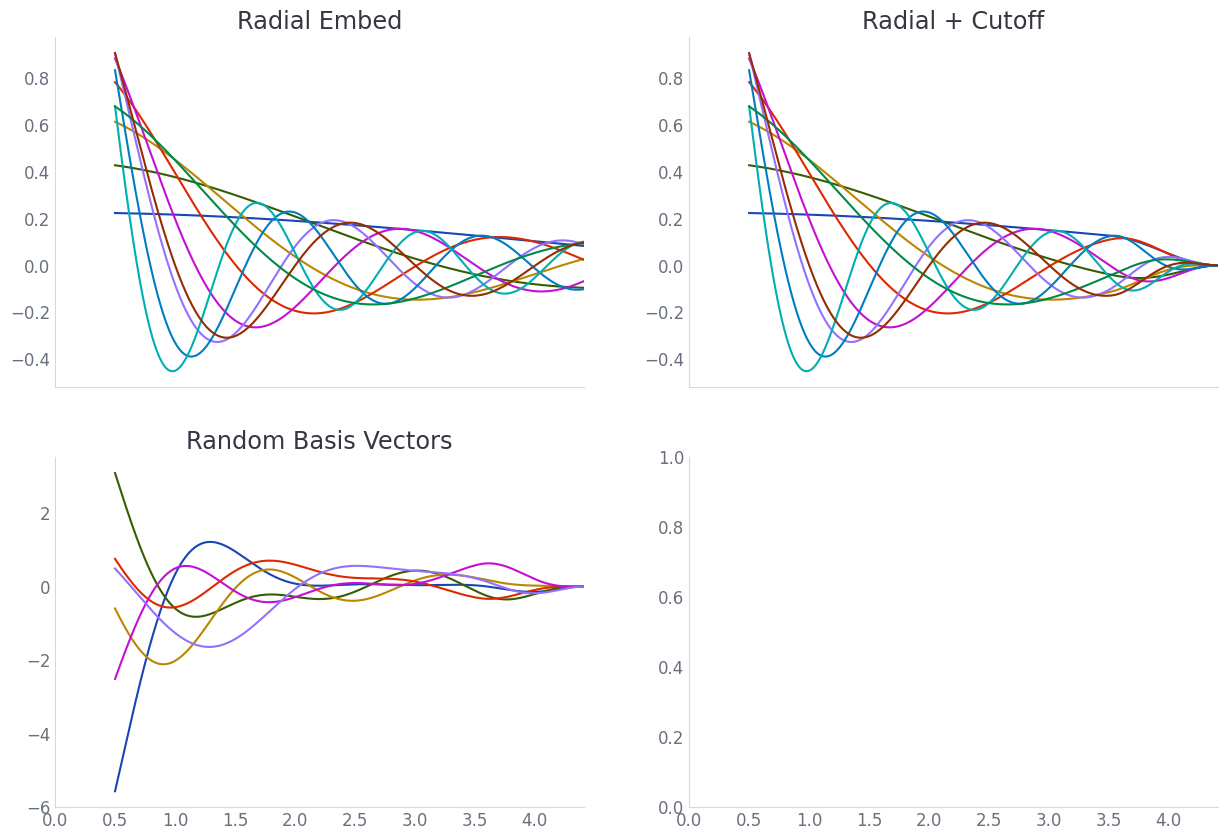

In [16]:
from facet.layers import Context


edge_embed = model.edge_embedding.bind({'params': ema_params['edge_embedding']})
rmax = ema_params['edge_embedding']['rmax'].item()

rr = jnp.linspace(0.5, rmax * 1, 1000)
ee = edge_embed.basis(rr, r_max=rmax, ctx=Context(training=False))
ee2 = edge_embed(rr, ctx=Context(training=False)).array
# for x in params['mace']['edge_embedding']['basis']['freq']:
#     plt.axvline(jnp.pi * x / radial_embed.r_max, lw=0.5, c='grey')
dip = rr[jnp.argmin(jnp.abs(jnp.diff(ee, axis=-1)), axis=0)]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
ax1.plot(rr, ee)
ax1.set_title('Radial Embed')
ax2.plot(rr, ee2)
ax2.set_title('Radial + Cutoff')

coefs = np.random.randn(ee.shape[-1], 6)
ax3.plot(rr, ee2 @ coefs)
ax3.set_title('Random Basis Vectors')

# ff = model.edge_embedding.basis.freq


# ax1.axvline(1 * jnp.pi / rmax * ff[4])
# for f in ff[7:]:
#     dip = (jnp.pi / 2) * rmax / f
#     if dip < rmax:
#         ax1.axvline(dip, lw=0.5, color='grey')

plt.xlim(0, rmax * 1)
plt.show()

<IPython.core.display.HTML object>

(-10.0, 10.0)

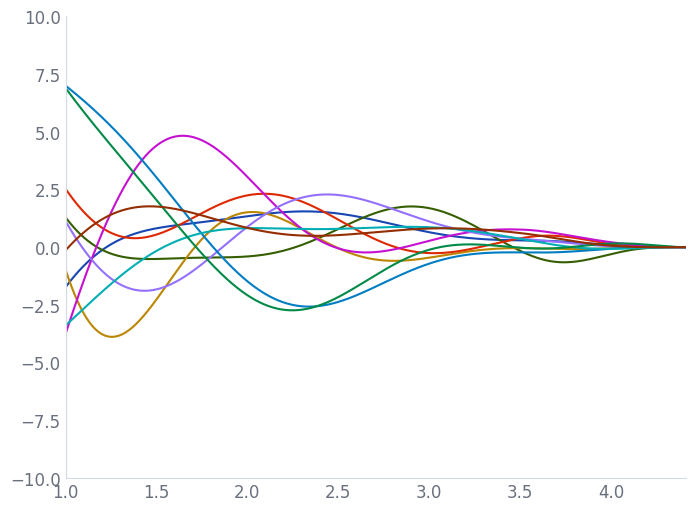

In [36]:
from facet.layers import shifted_softplus
from flax import linen as nn

from facet.utils import intercept_stat

layer_i = 2

mlp_mod_params = ema_params['mace'][f'layer_{layer_i}']['interaction']['SimpleInteraction_0']['SevenNetConv_0']['LazyInMLP_0']

mlp_mod = mod.mace.layers[layer_i].interaction.interaction.conv.radial_weight.copy(out_dim=mlp_mod_params['Dense_0']['kernel'].shape[-1], inner_act=jax.nn.silu)

# with nn.intercept_methods(intercept_stat):
ww = mlp_mod.apply({'params': mlp_mod_params}, x=ee2, ctx=Context(training=False))

plt.plot(rr, ww[..., ::101]);
plt.xlim(1, rmax)
plt.ylim(-10, 10)
# plt.yscale('symlog')

<IPython.core.display.HTML object>

<Axes: >

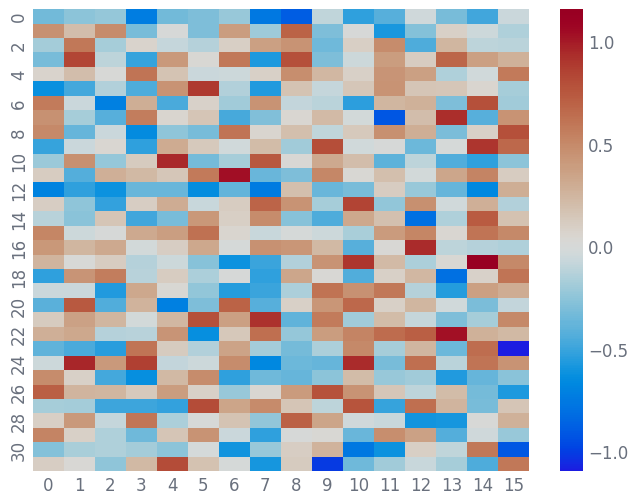

In [38]:
s2_sc = mod.mace.layers[-2].self_connection
s2_sc_params = ema_params['mace']['layer_2']['self_connection']

sns.heatmap(s2_sc_params['mlp']['Dense_0']['kernel'], center=0, cmap='rho_diverging')

In [61]:
import e3nn_jax as e3nn
from facet.layers import Context
xyz_grid = jnp.mgrid[-2:2:6j, -2:2:6j, -2:2:6j].swapaxes(0, -1).reshape(-1, 3)

# x = e3nn.normal('262x0e + 1x1e + 87x1e + 52x2e', leading_shape=(1,), normalization='norm',
# key=jr.key(29205))
x = e3nn.normal('128x0e + 1x1e + 63x1e + 32x2e', leading_shape=(1,), normalization='norm', key=jr.key(29206))
x = x.broadcast_to((*xyz_grid.shape[:-1], x.shape[-1]))
chunks = x.chunks
chunks[1] = xyz_grid[:, None, :]
x = e3nn.from_chunks(x.irreps, chunks, leading_shape=x.shape[:-1]).regroup()
rot = e3nn.angles_to_matrix(0.3, 0.8, 1.2)
x_rot = x.transform_by_matrix(rot)
y = s2_sc(x, node_specie=None, species_embed=None, ctx=Context(training=False))
y_rot = s2_sc(x_rot, node_specie=None, species_embed=None, ctx=Context(training=False))
y2 = y.transform_by_matrix(rot)

print(y_rot - y2)
print(jnp.mean(jnp.abs(e3nn.norm(y_rot - y2).array)), jnp.mean(jnp.abs(e3nn.norm(y_rot).array)))

128x0e+64x1e+32x2e
[[ 1.0495782e-03 -8.8953972e-04  5.5747852e-04 ...  1.6210079e-03
  -7.2126091e-04  4.5576692e-03]
 [ 5.3727627e-04 -8.6903572e-05  3.5480456e-04 ...  1.4085174e-03
  -1.1635572e-04  4.5988560e-03]
 [-3.3152103e-04  6.7257881e-04  1.1802744e-04 ...  7.0667267e-04
   3.0504540e-04  3.2876879e-03]
 ...
 [-6.8485737e-04 -7.2395802e-04 -8.9404825e-04 ...  1.2911558e-03
   9.2912838e-04  4.9576163e-05]
 [-2.7817488e-04 -5.8388710e-04 -1.0104533e-03 ...  6.2143803e-04
   1.5106983e-03 -4.4909120e-04]
 [ 2.5439262e-04  3.6275387e-04 -1.0074293e-03 ... -2.6828051e-04
   2.1605194e-03 -7.2202086e-04]]
0.004095566 0.41102502


In [62]:
def make_xy(y):
    return jnp.concat([x_rot.filter('1e').array.reshape(x.shape[0], -1, 3)[:, 0, :], y.filter('1e').array.reshape(y.shape[0], -1, 3)[:, 0, :]], axis=-1)

xy = make_xy(y_rot)
xy2 = make_xy(y2)

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
# sns.heatmap(xy.T, square=True, cbar=False, cmap='rho_heatmap', ax=ax1)
# sns.heatmap(xy2.T, square=True, cbar=False, cmap='rho_heatmap', ax=ax2)
# plt.show()

import plotly.graph_objects as go

xx, yy, zz, uu, vv, ww = xy.T

# go.Figure(go.Cone(x=xx, y=yy, z=zz, u=uu, v=vv, w=ww))

from plotly.subplots import make_subplots
from matplotlib.colors import rgb2hex
color = xyz_grid
color = (color - jnp.min(color.reshape(-1))) / jnp.ptp(color.reshape(-1))
rgb = [rgb2hex(c.tolist()) for c in color]

fig = make_subplots(rows=1, cols=3, specs=[[{'is_3d': True}] * 3])

xx2, yy2, zz2, uu2, vv2, ww2 = xy2.T

fig.add_trace(go.Scatter3d(x=xx, y=yy, z=zz, marker_color=rgb, mode='markers'), 1, 1)
fig.add_trace(go.Scatter3d(x=uu, y=vv, z=ww, marker_color=rgb, mode='markers'), 1, 2)
fig.add_trace(go.Scatter3d(x=uu2, y=vv2, z=ww2, marker_color=rgb, mode='markers'), 1, 3)

In [67]:
from facet.data.dataset import dataloader

num_test, test_dl = dataloader(config, split='test')

In [72]:
from facet.layers import Context
batch = jax.tree.map(lambda x: x[0], next(iter(test_dl)))
# batch = jax.tree.map(lambda x: x[0], jax.device_put(next(iter(test_dl)), jax.devices()[0]))

preds = mod(batch, ctx=Context(training=False))

In [74]:
import e3nn_jax as e3nn

new_batch1, rots1 = batch.rotate(1234)
new_preds1 = mod(new_batch1, ctx=Context(training=False))


new_batch2, rots2 = batch.rotate(4321)
new_preds2 = mod(new_batch2, ctx=Context(training=False))

<IPython.core.display.HTML object>

<matplotlib.collections.PathCollection object at 0x7df6623b1d30>

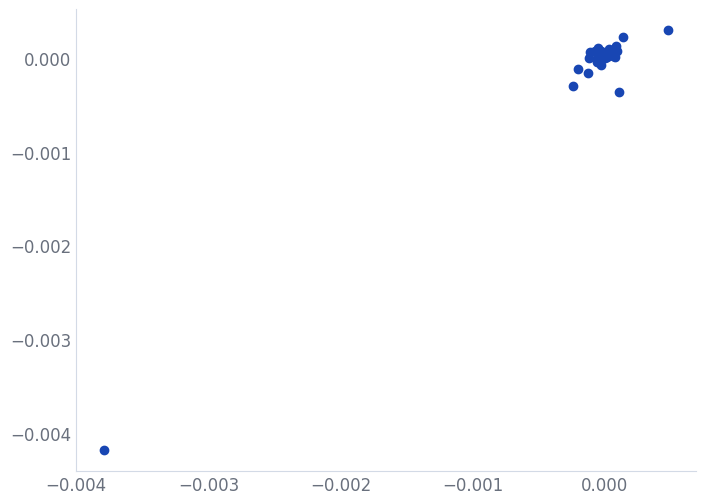

In [75]:
plt.scatter(preds - new_preds1, preds - new_preds2)

<IPython.core.display.HTML object>

<matplotlib.collections.PathCollection object at 0x7df661e16b10>

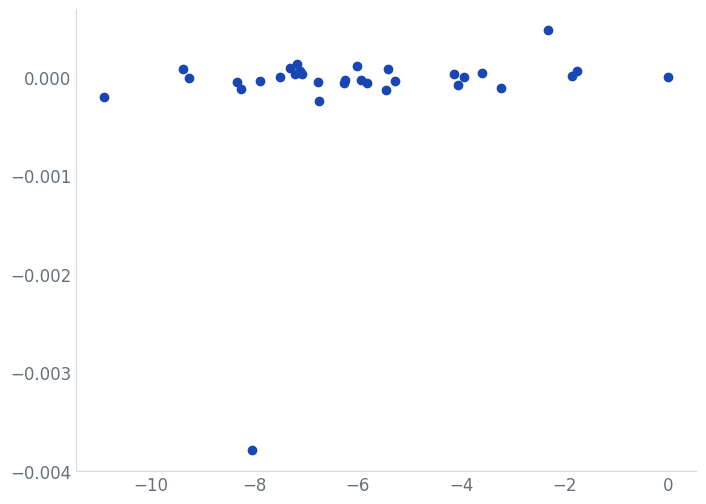

In [76]:
plt.scatter(preds, preds - new_preds1)

In [78]:
from collections.abc import Sequence
import plotly.express as px
import plotly.graph_objects as go
from pymatgen.core import Element
from pymatgen.core import Structure
from facet.data.databatch import CrystalGraphs

# elements = config.data.metadata['elements']
jmol = pd.read_csv('https://raw.githubusercontent.com/CorySimon/JMolColors/master/jmolcolors.csv').set_index('atom')
jmol_map = {
    i: '#' + row['Hex']
    for i, row in jmol.iterrows()
}

def cg_to_struct(cg: CrystalGraphs, batch_i: int = 0):
    mask = (cg.nodes.graph_i == batch_i) & cg.padding_mask[cg.nodes.graph_i]    
    coords = np.array(cg.nodes.cart)[mask]
    species_i = np.array(cg.nodes.species)[mask]
    species = [Element.from_Z(i) for i in species_i]
    lat = cg.globals.lat[batch_i]
    return Structure(lat, species, coords, coords_are_cartesian=True)

def plot_struct(structs: Structure | Sequence[Structure], last_frame='actual', use_cartesian=False):
    if isinstance(structs, Structure):
        structs = [structs]
    
    sdfs = []
    for i, struct in enumerate(structs):
        if use_cartesian:
            sdf = pd.DataFrame(struct.cart_coords, columns=['x', 'y', 'z'])
        else:            
            sdf = pd.DataFrame(struct.frac_coords % 1, columns=['x', 'y', 'z'])
        sdf['atom'] = struct.species
        sdf['frame'] = i
        if last_frame is not None and i == len(structs) - 1:
            sdf['frame'] = last_frame
        sdfs.append(sdf)

    sdf = pd.concat(sdfs)
    if use_cartesian:
        xyz = struct.cart_coords.reshape(-1)
        ptp = np.ptp(xyz)
        range_xyz = [min(xyz) - 0.1 * ptp, max(xyz) + 0.1 * ptp]
    else:
        range_xyz = [-0.05, 1.05]
    return px.scatter_3d(sdf, x='x', y='y', z='z', color='atom', color_discrete_map=jmol_map, animation_frame='frame',
                         range_x=range_xyz, range_y=range_xyz, range_z=range_xyz)

batch_i = jnp.argmax(jnp.abs(preds - new_preds1)).item()
# plot_struct(struct)
fig = plot_struct([cg_to_struct(new_batch1, batch_i), cg_to_struct(new_batch2, batch_i)], use_cartesian=False)
fig.update_layout(scene_aspectmode='cube')

In [93]:
from facet.layers import Context
from tqdm import tqdm
from itertools import islice


num_test, test_dl = dataloader(config, split='valid')
# num_test = 100

predict = jax.jit(lambda b: model.apply({'params': ema_params}, cg=b, ctx=Context(training=False)))

test_preds = []

if True:
    batches = []
    for batch in tqdm(islice(test_dl, num_test), total=num_test//3):
        for i in range(3):
            batches.append(jax.tree.map(lambda x: x[i], batch))
            test_preds.append(predict(batches[-1]))
else:
    for batch in tqdm(batches):
        test_preds.append(predict(batch))

# aug_preds = []
# aug_batches = []

# aug_rng = np.random.default_rng(413)
# aug_rots = []
# for batch in tqdm(batches[:num_test]):
#     aug_batch, aug_rot = batch.rotate(aug_rng.integers(1, 1000))    
#     aug_rots.append(aug_rot)
#     aug_batches.append(aug_batch)
#     aug_preds.append(predict(aug_batches[-1]))

  0%|          | 0/1447 [00:00<?, ?it/s]

100%|██████████| 1447/1447 [02:48<00:00,  8.59it/s]


MAE:	0.0287
RMSE:	0.0599


<IPython.core.display.HTML object>

Text(0, 0.5, 'Actual')

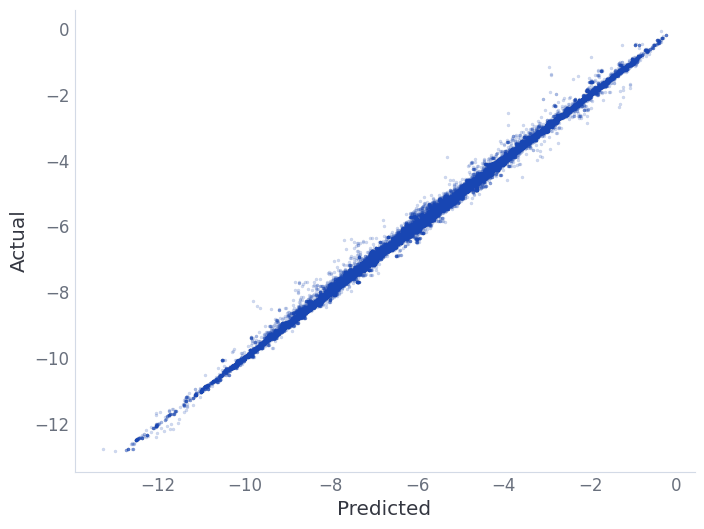

In [94]:
yhat = jnp.stack(test_preds).astype(jnp.float32).reshape(-1)
# aug_yhat = jnp.stack(aug_preds).astype(jnp.float32).reshape(-1)
y = jnp.stack([batch.e_form for batch in batches]).astype(jnp.float32).reshape(-1)

dataset_id = jnp.stack([batch.graph_data.dataset_id for batch in batches]).reshape(-1)

mask = jnp.stack([batch.padding_mask for batch in batches]).reshape(-1)

y, yhat, dataset_id = y[mask], yhat[mask], dataset_id[mask]

df = pd.DataFrame({'y': y, 'yhat': yhat, 'id': dataset_id})
df.to_feather('data/enb136-ema-valid.feather')
# aug_yhat = aug_yhat[mask]
print('MAE:\t{:.4f}'.format(jnp.mean(jnp.abs(yhat - y))))
print('RMSE:\t{:.4f}'.format(jnp.sqrt(jnp.mean(jnp.square(yhat - y)))))
# print('Equiv:\t{:.4g}'.format(jnp.mean(jnp.abs(aug_yhat - yhat))))
sns.scatterplot(x=yhat, y=y, ec=None, alpha=0.2, s=5)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
sns.displot(aug_yhat - yhat)

In [ ]:
sns.boxplot(x=y, hue=jnp.abs(aug_yhat - yhat) > 0.001)

In [ ]:
sns.boxplot(x=jnp.clip(jnp.abs(yhat - y), 0, 0.4), hue=jnp.abs(aug_yhat - yhat) > 0.001)

In [ ]:
from scipy.stats import spearmanr
spearmanr(jnp.abs(yhat - y), jnp.abs(aug_yhat - yhat))

In [ ]:
ii = jnp.repeat(jnp.arange(len(batches))[..., None], len(test_preds[0]), axis=-1).reshape(-1)
jj = jnp.repeat(jnp.arange(len(test_preds[0]))[None, ...], len(batches), axis=0).reshape(-1)

ii[4], jj[4]

In [ ]:
inds = jax.lax.top_k(np.abs(aug_yhat - yhat), k=50)[-1]
ind = inds[2]
i = ii[mask][ind].item()
j = jj[mask][ind].item()
print(i, j)

In [ ]:
print(batches[i].e_form[j])
print(test_preds[i][j])
print(aug_preds[i][j])

In [ ]:
dataset_ids = []
for i, j in zip(ii[mask][inds], jj[mask][inds]):
    print('{:8.3f} {:8.3f} {:8.3f}'.format(batches[i].e_form[j], test_preds[i][j].item(), aug_preds[i][j].item()))
    dataset_ids.append(batches[i].graph_data.dataset_id[j].item())

dataset_ids

In [ ]:
struct = cg_to_struct(batches[i], j)
print(struct)
# print(cg_to_struct(batches[i], j).to_file('ta.poscar', fmt='poscar'))

In [ ]:
batches[i].graph_data.dataset_id[j]

In [38]:
df = pd.read_feather('precomputed/mptrj/summary.feather')

el_cols = []
for el in Element:
    if el.symbol in df.columns:
        el_cols.append(el.symbol)
        df[el.symbol] = df[el.symbol].fillna(0).astype(np.uint64)

In [ ]:
from pymatgen.core import Composition
bad_df = df[df['dataset_id'].isin(dataset_ids)]

comps = [Composition(row[el_cols].to_dict()) for i, row in bad_df.iterrows()]
print(', '.join(list(map(str, comps))))

In [ ]:
bad_df.iloc[0]

In [ ]:
def find(dataset_id):
    for num in range(2 ** 5):
        potential_id = str(int(np.binary_repr(num) + np.binary_repr(dataset_id, width=32), base=2))
        if potential_id[0] in '12' and potential_id[-4] in '01' and '0' in potential_id[-3:]:
            print(np.binary_repr(num), potential_id)

find(-706419692)

In [ ]:
sns.kdeplot(bad_df[['alpha', 'beta', 'gamma']].values.reshape(-1))
sns.kdeplot(df.sample(1000)[['alpha', 'beta', 'gamma']].values.reshape(-1))

In [ ]:
bins = sorted([c for c in df.columns if c.startswith('bin_')])
normed = bad_df[bins] / bad_df[bins].sum(axis=1).values.reshape(-1, 1)
ref_normed = df[bins] / df[bins].sum(axis=1).values.reshape(-1, 1)

xx = [float(x.removeprefix('bin_')) for x in normed.columns]


plt.plot(xx, normed.mean(axis=0))
plt.plot(xx, ref_normed.mean(axis=0))
plt.axvline(model.edge_embedding.param_rmax)